In [ ]:
!pip install scikit-survival
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install lifelines
!pip install torchtuples
!pip install pycox
! pip install --upgrade xgboost
!pip install xgbse

     |████████████████████████████████| 2.5 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.0-cp37-cp37m-linux_x86_64.whl size=4080343 sha256=da2f2c0c4cb57f6e98901ebed4ac8655330dc98a99de1c8a220e832b25bf4467
  Stored in directory: /root/.cache/pip/wheels/91/c1/99/2c2faacc82ff4f89d27612b1fd905ea35aa24f6a93dd4dcc0d
Successfully built scikit-survival
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,928 kB/s)
debconf: unable to initialize front

In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import math
import pickle
import copy
import seaborn as sns
from numpy import sqrt 

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False 

pd.options.display.float_format = '{:.5f}'.format

import warnings 
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import random
from keras.callbacks import EarlyStopping

from sklearn.pipeline import make_pipeline
from sksurv.ensemble import RandomSurvivalForest
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

from xgbse._kaplan_neighbors import DEFAULT_PARAMS
from xgbse.metrics import concordance_index

# importing model and utils from xgbse
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured
from lifelines import CoxPHFitter

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
prediction_median_total = pd.DataFrame()

# Model 1: Deepsurv

In [ ]:
def deepsurv(dataset, start_col, end_col): 
    
    df_preprocessed = dataset.copy(deep=True)
    
    df_train, df_test = train_test_split(df_preprocessed, test_size=0.3, random_state=30)
    df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=30)
    
    cols_leave = list(df_preprocessed.loc[:, start_col:end_col].columns)
    leave = [(col, None) for col in cols_leave]
    x_mapper = DataFrameMapper(leave)
    
    x_train = x_mapper.fit_transform(df_train).astype('float32')
    x_val = x_mapper.transform(df_val).astype('float32')
    x_test = x_mapper.transform(df_test).astype('float32')
    
    get_target = lambda df: (df_preprocessed['y_cum_time'].values, df_preprocessed['event'].values)
    y_train = (df_preprocessed.loc[df_train.index,'y_cum_time'].values, df_preprocessed.loc[df_train.index,'event'].values)
    y_val = (df_preprocessed.loc[df_val.index,'y_cum_time'].values, df_preprocessed.loc[df_val.index,'event'].values)
    durations_test, events_test = (df_preprocessed.loc[df_test.index,'y_cum_time'].values, df_preprocessed.loc[df_test.index,'event'].values)
    val = x_val, y_val
    
    # Neural Net
    in_features = x_train.shape[1]
    num_nodes = [64, 64, 64, 64]
    out_features = 1
    batch_norm = True
    dropout = 0.1
    output_bias = False

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                  dropout, output_bias=output_bias)
    
    # Training The Model 
    model = CoxPH(net, tt.optim.Adam)
    batch_size = 128
    model.optimizer.set_lr(0.01)

    epochs = 1000
    callbacks = [tt.callbacks.EarlyStopping(patience=10)]
    verbose = True
    
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
    
    # Prediction 
    _ = model.compute_baseline_hazards()
    surv = model.predict_surv_df(x_test)
    
    # Evaluation 
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

    print("concordance_td: ",ev.concordance_td())
    print("integrated_brier_score:", ev.integrated_brier_score(time_grid))
    print("integrated_nbll:", ev.integrated_nbll(time_grid))

    return surv


def predicted_median(result_surv):
    # Predictied median time
    pred_df = pd.DataFrame()
    pred_df['lamp_idx'] = list(result_surv.columns)
    pred_df['predicted_time'] = 0

    for col in list(result_surv.columns):
        val = max(result_surv[col][result_surv[col]>=0.5].index)
        pred_df.loc[col, 'predicted_time'] = val
        
    return pred_df

In [ ]:
df_autoencoder = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/7.Autoencoder.xlsx')

In [ ]:
result_deepsurv = deepsurv(df_autoencoder, df_autoencoder.columns[1], df_autoencoder.columns[-3])

0:	[0s / 0s],		train_loss: 3.3776,	val_loss: 6.8233
1:	[0s / 0s],		train_loss: 3.2938,	val_loss: 6.5038
2:	[0s / 0s],		train_loss: 3.2233,	val_loss: 4.7821
3:	[0s / 0s],		train_loss: 3.2450,	val_loss: 3.3099
4:	[0s / 0s],		train_loss: 3.2302,	val_loss: 30.4374
5:	[0s / 0s],		train_loss: 3.2348,	val_loss: 72.5510
6:	[0s / 0s],		train_loss: 3.2475,	val_loss: 81.2664
7:	[0s / 0s],		train_loss: 3.0754,	val_loss: 54.9961
8:	[0s / 0s],		train_loss: 3.1744,	val_loss: 27.4172
9:	[0s / 0s],		train_loss: 3.2071,	val_loss: 8.6638
10:	[0s / 0s],		train_loss: 3.2166,	val_loss: 7.5566
11:	[0s / 0s],		train_loss: 3.1239,	val_loss: 19.9104
12:	[0s / 0s],		train_loss: 3.2786,	val_loss: 32.4065
13:	[0s / 0s],		train_loss: 3.1907,	val_loss: 46.6060
concordance_td:  0.7267025089605734
integrated_brier_score: 0.10532909180924258
integrated_nbll: 0.3488008051432166


###  각 램프별 Predicted Time에 대한 Median 값 확인

In [ ]:
df_preprocessed = df_autoencoder.copy(deep=True)
df_train, df_test = train_test_split(df_preprocessed, test_size=0.3, random_state=30)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=30)

In [ ]:
predicted_median(result_deepsurv)

,lamp_idx,predicted_time
0,0,660.42000
1,1,715.85000
2,2,678.42000
3,3,729.50000
4,4,458.42000
...,...,...
85,85,1184.85000
86,86,602.12000
87,87,674.08000
88,88,416.05000


In [ ]:
pred_ = predicted_median(result_deepsurv)
pred_ 

,lamp_idx,predicted_time
0,0,660.42000
1,1,715.85000
2,2,678.42000
3,3,729.50000
4,4,458.42000
...,...,...
85,85,1184.85000
86,86,602.12000
87,87,674.08000
88,88,416.05000


In [ ]:
prediction_median_total['lamp_idx'] = pred_['lamp_idx']
prediction_median_total['deepsurv_pred'] = pred_ ['predicted_time']

# Model 2: Random Survival Forest

### Read Dataset

In [ ]:
data7 = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/7.Autoencoder.xlsx')

### Modeling

In [ ]:
class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

In [ ]:
y = ['y_cum_time', 'event','Lot No.']
i = 6
X = globals()['data{}'.format(i+1)].drop(y,axis = 1)
Y = pd.DataFrame(columns = ['obs', 'value'])
Y['obs'] = globals()['data{}'.format(i+1)].apply(lambda x: True if x['event'] == 1 else False, axis = 1)
Y['value'] = globals()['data{}'.format(i+1)]['y_cum_time']
y_new = np.empty(dtype=[('obs', bool), ('value', np.float64)], shape = Y.shape[0])
y_new['obs'] = (Y['obs'] == True).values
y_new['value'] = Y['value'].values

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.3, random_state=30)

globals()['rsf{}'.format(i+1)] = make_pipeline(RandomSurvivalForest(random_state=610))
globals()['rsf{}'.format(i+1)].fit(X_train, y_train)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(globals()['rsf{}'.format(i+1)], param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=610)
model_random_search.fit(X_train, y_train)
print("< data"+str(i+1)+" >")
print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth'] #7
max_features = model_random_search.best_params_['randomsurvivalforest__max_features'] #5
min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf'] #17

globals()['rsf_best{}'.format(i+1)] = RandomSurvivalForest(random_state=610, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf)
globals()['rsf_best{}'.format(i+1)].fit(X_train, y_train)
globals()['rsf_best{}'.format(i+1)].score(X_test, y_test)

< data7 >
The c-index of random survival forest using a RandomizedSearchCV is 0.700
The best set of parameters is: {'randomsurvivalforest__max_depth': 7, 'randomsurvivalforest__max_features': 5, 'randomsurvivalforest__min_samples_leaf': 17}


0.6996410946612831

In [ ]:
result = pd.DataFrame()
column_name = []
for i in range(0,len(X_test)):
    column_name.append(y_test[i][1])
    result[i] = rsf_best7.predict_survival_function(X_test)[i].y
result.index = rsf_best7.predict_survival_function(X_test)[0].x
result.columns = column_name
result

,476.28000,535.42000,1192.42000,682.50000,276.10000,427.15000,1023.33000,3695.63000,295.77000,344.10000,641.07000,656.83000,2939.93000,976.62000,885.27000,170.10000,535.92000,352.58000,858.57000,893.30000,398.73000,609.07000,3015.00000,150.08000,649.70000,520.35000,476.00000,5659.35000,553.23000,2574.20000,364.42000,393.85000,858.57000,1199.07000,606.12000,441.95000,412.10000,476.00000,132.00000,989.72000,...,3902.70000,142.18000,408.10000,774.50000,900.57000,1041.85000,916.13000,2835.37000,1039.47000,799.42000,665.78000,2574.20000,574.92000,535.42000,907.92000,278.10000,654.08000,948.45000,221.37000,448.12000,488.35000,327.20000,325.25000,729.50000,2499.42000,3767.07000,402.85000,492.47000,574.28000,1017.25000,81.85000,1015.33000,867.70000,1148.42000,632.63000,1124.35000,437.85000,636.43000,182.28000,371.92000
22.13000,0.99966,0.99892,1.00000,1.00000,0.98729,1.00000,1.00000,1.00000,0.99627,0.99718,1.00000,0.97843,1.00000,1.00000,1.00000,0.97117,1.00000,0.98772,1.00000,1.00000,0.99525,0.99955,1.00000,1.00000,1.00000,1.00000,0.99379,1.00000,0.99688,1.00000,0.99299,1.00000,1.00000,1.00000,1.00000,0.97117,1.00000,1.00000,0.99595,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.97346,1.00000,1.00000,1.00000,0.99960,1.00000,1.00000,0.99798,1.00000,0.99668,1.00000,0.97117,0.97622,0.99941,0.99967,1.00000,1.00000,1.00000,1.00000,1.00000,0.99938,1.00000,0.99724,1.00000,0.99967,1.00000,1.00000,0.99926,1.00000,1.00000,0.99926,1.00000,0.98888,0.99813
101.63000,0.99136,0.99487,0.99340,0.98885,0.98729,0.99114,0.99977,0.99977,0.99312,0.99447,0.99977,0.97843,0.99977,0.99977,0.99413,0.97117,0.99977,0.98705,0.99916,0.99271,0.99310,0.99599,0.99977,0.99900,0.98394,0.99737,0.99200,0.99977,0.99514,0.99977,0.99120,0.98755,0.98933,0.98607,0.99271,0.97117,0.99719,0.98720,0.99190,0.99977,...,0.99977,0.99738,0.99775,0.99461,0.99215,0.99977,0.97346,0.99977,0.99929,0.98932,0.99555,0.99977,0.99388,0.99343,0.99977,0.99355,0.98999,0.97117,0.97592,0.99478,0.99512,0.98845,0.99670,0.99569,0.99977,0.99977,0.99619,0.99593,0.99483,0.99977,0.99512,0.99977,0.99977,0.99385,0.99123,0.99977,0.99385,0.98562,0.98858,0.99491
150.08000,0.97097,0.97876,0.99046,0.98463,0.98729,0.97817,0.99954,0.99954,0.98064,0.99018,0.99954,0.97763,0.99954,0.99954,0.98720,0.97037,0.99954,0.98665,0.99861,0.98895,0.98321,0.98692,0.99954,0.99723,0.97133,0.99494,0.98173,0.99954,0.99383,0.99954,0.98050,0.98118,0.97421,0.97627,0.98895,0.97037,0.99460,0.97013,0.97627,0.99954,...,0.99954,0.99344,0.99276,0.99314,0.98796,0.99904,0.97266,0.99954,0.99906,0.98433,0.98088,0.99954,0.99130,0.97637,0.99954,0.98067,0.98348,0.97037,0.97592,0.99105,0.98029,0.96831,0.99188,0.99296,0.99954,0.99954,0.99445,0.99077,0.99305,0.99954,0.98010,0.99954,0.99954,0.97685,0.98796,0.99954,0.97786,0.97703,0.98858,0.98099
153.70000,0.97058,0.97837,0.99046,0.98463,0.97046,0.97817,0.99954,0.99954,0.97630,0.98574,0.99954,0.95357,0.99954,0.99954,0.98720,0.93920,0.99954,0.97403,0.99861,0.98895,0.97690,0.98550,0.99954,0.99723,0.97133,0.99494,0.97392,0.99954,0.98935,0.99954,0.97246,0.98118,0.97421,0.97627,0.98895,0.94090,0.99352,0.97013,0.97262,0.99954,...,0.99954,0.99344,0.99276,0.99314,0.98796,0.99904,0.94217,0.99954,0.99906,0.98433,0.98021,0.99954,0.99130,0.97494,0.99954,0.97558,0.98348,0.94024,0.95207,0.99105,0.98029,0.96831,0.99154,0.99296,0.99954,0.99954,0.99307,0.99077,0.98948,0.99954,0.98010,0.99954,0.99954,0.97580,0.98796,0.99954,0.97747,0.97703,0.97504,0.97838
170.28000,0.97018,0.97713,0.99046,0.98463,0.95500,0.97817,0.99954,0.99954,0.97095,0.98284,0.99954,0.92989,0.99954,0.99954,0.98720,0.91427,0.99954,0.96586,0.99861,0.98895,0.96917,0.98422,0.99954,0.99723,0.97133,0.99494,0.96579,0.99954,0.98387,0.99954,0.96382,0.98118,0.97421,0.97627,0.98895,0.91640,0.99275,0.97013,0.96896,0.99954,...,0.99954,0.99344,0.99276,0.99314,0.98796,0.99904,0.91559,0.99954,0.99906,0.98433,0.97973,0.99954,0.99130,0.97256,0.99954,0.97026,0.98348,0.91573,0.93221,0.99105,0.97993,0.96831,0.99120,0.99296,0.99954,0.99954,0.99115,0.99077,0.98

In [ ]:
pred = []
real = []
check = []
for j in range(len(result.columns)):
    real.append(y_test[j][1])
    check.append(y_test[j][0])
    for i in range(len(result)):
        if result.iloc[len(result)-1, j] >= 0.5:
            pred.append(result.index[len(result)-1])
            break
            
        elif result.iloc[i,j] < 0.5:
            #print(result.iloc[i-1:i+1,j])
            a = result.iloc[i-1,j] - 0.5
            b = 0.5 - result.iloc[i,j] 
            v = (a*result.index[i]+b*result.index[i-1])/(a+b)
            #print(pred)
            pred.append(v)
            break

prediction = pd.DataFrame()
prediction['pred'] = pred
prediction['real'] = real
prediction['gas_leak'] = check
prediction

,pred,real,gas_leak
0,636.46945,476.28000,True
1,709.73156,535.42000,False
2,628.87458,1192.42000,False
3,620.54559,682.50000,False
4,457.05718,276.10000,True
...,...,...,...
85,1669.63296,1124.35000,False
86,625.95751,437.85000,True
87,614.79663,636.43000,False
88,468.99972,182.28000,True


In [ ]:
prediction_median_total['rsf_pred'] = prediction['pred']

# Model 3: XGBSE

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/FactoryHack2022/Final/data/7.Autoencoder.xlsx')

df = df.drop(['Lot No.'], axis = 1)

encoding_dict = {0 : False, 1 : True}

df['event'] = df['event'].replace(encoding_dict)
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,y_cum_time,event
0,0,12.72207,0.75875,0.00000,0.00000,13.20727,9.58227,11.46648,0.00000,0.00000,858.57000,False
1,0,15.58812,1.22096,0.00000,0.00000,15.53573,11.40023,14.28586,0.00000,0.00000,858.57000,False
2,0,13.74153,1.26162,0.00000,0.00000,14.72933,10.03433,12.27998,0.00000,0.00000,858.57000,False
3,0,14.83929,1.66683,0.00000,0.00000,14.26060,11.12708,13.22583,0.00000,0.00000,858.57000,False
4,0,14.91138,2.27734,0.00000,0.00000,13.86756,11.28256,12.41187,0.00000,0.00000,838.28000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,10.46573,0.00000,0.00000,0.00000,14.69375,4.27937,4.92478,0.00000,0.00000,956.02000,True
296,0,14.54113,1.33644,0.00000,0.00000,17.40959,7.62617,8.61867,0.00000,0.00000,946.02000,True
297,0,14.14203,0.63185,0.00000,0.00000,17.82745,7.06528,8.12010,0.00000,0.00000,520.35000,True
298,0,5.99447,0.00000,0.00000,0.00000,10.30068,1.88037,1.39661,0.56868,0.00000,234.13000,True


In [ ]:
train, test = train_test_split(df, test_size = 0.3, random_state = 30)

X_train = train.drop(['event', 'y_cum_time'], axis = 1)
X_test = test.drop(['event', 'y_cum_time'], axis = 1)

y_train = np.array(list(zip(train['event'], train['y_cum_time'])), dtype = "?,f")
y_test = np.array(list(zip(test['event'], test['y_cum_time'])), dtype = "?,f")

# chaning parameter
DEFAULT_PARAMS['aft_loss_distribution_scale'] = 0.75

# training model
xgbse_model = XGBSEKaplanNeighbors(DEFAULT_PARAMS, n_neighbors=25)
xgbse_model.fit(
    X_train, y_train,
    validation_data = (X_train, y_train),
    early_stopping_rounds=10,
    time_bins=np.arange(0, 6000, 30)
)

# predicting and evaluating
preds = xgbse_model.predict(X_test)
cind = concordance_index(y_test, preds)

print(f"C-index: {cind:.3f}")
print("----")

C-index: 0.682
----


In [ ]:
import copy
result = copy.deepcopy(preds.T)

pred = []
real = []
check = []
for j in range(len(result.columns)):
    real.append(y_test[j][1])
    check.append(y_test[j][0])
    for i in range(len(result)):
        if result.iloc[len(result)-1, j] >= 0.5:
            pred.append(result.index[len(result)-1])
            break
            
        elif result.iloc[i,j] < 0.5:
            #print(result.iloc[i-1:i+1,j])
            a = result.iloc[i-1,j] - 0.5
            b = 0.5 - result.iloc[i,j] 
            v = (a*result.index[i]+b*result.index[i-1])/(a+b)
            #print(pred)
            pred.append(v)
            break

prediction = pd.DataFrame()
prediction['pred'] = pred
prediction['real'] = real
prediction['gas_leak'] = check
prediction

,pred,real,gas_leak
0,605.83636,476.28000,True
1,604.52153,535.41998,False
2,660.68182,1192.42004,False
3,616.04167,682.50000,False
4,436.66950,276.10001,True
...,...,...,...
85,3084.81605,1124.34998,False
86,600.23864,437.85001,True
87,608.22115,636.42999,False
88,484.44643,182.28000,True


In [ ]:
prediction_median_total['xgbse_pred'] = prediction['pred']

- 최종 예상 램프 수명은 'ensemble' 컬럼

In [ ]:
prediction_median_total['ensemble'] = (prediction_median_total['deepsurv_pred']+prediction_median_total['rsf_pred']+prediction_median_total['xgbse_pred'])/3
prediction_median_total['gas_leak'] = prediction['gas_leak']
prediction_median_total['real'] = prediction['real']
prediction_median_total

,lamp_idx,deepsurv_pred,rsf_pred,xgbse_pred,ensemble,gas_leak,real
0,0,660.42000,636.46945,605.83636,634.24194,True,476.28000
1,1,715.85000,709.73156,604.52153,676.70103,False,535.41998
2,2,678.42000,628.87458,660.68182,655.99213,False,1192.42004
3,3,729.50000,620.54559,616.04167,655.36242,False,682.50000
4,4,458.42000,457.05718,436.66950,450.71556,True,276.10001
...,...,...,...,...,...,...,...
85,85,1184.85000,1669.63296,3084.81605,1979.76634,False,1124.34998
86,86,602.12000,625.95751,600.23864,609.43872,True,437.85001
87,87,674.08000,614.79663,608.22115,632.36593,False,636.42999
88,88,416.05000,468.99972,484.44643,456.49872,True,182.28000


- 실제 값과 예측 값의 차이 비교 


> 1. 전체데이터



findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


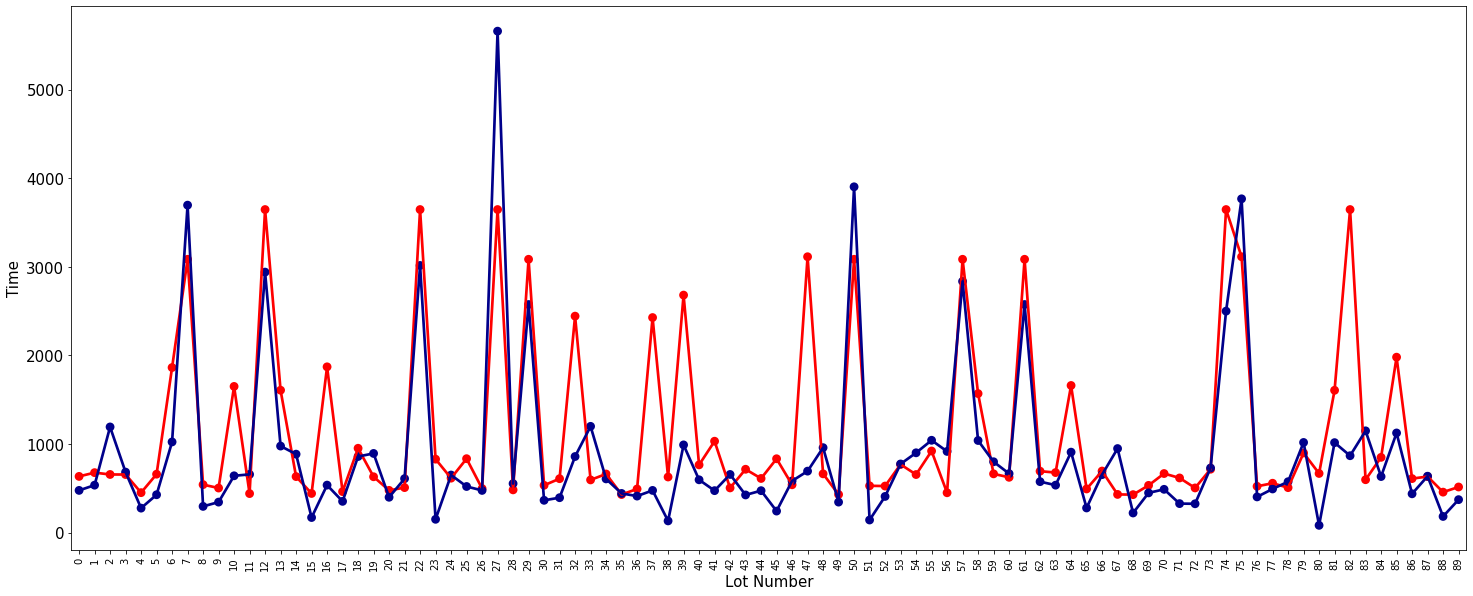

In [ ]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='ensemble', data=prediction_median_total.reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction_median_total.reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

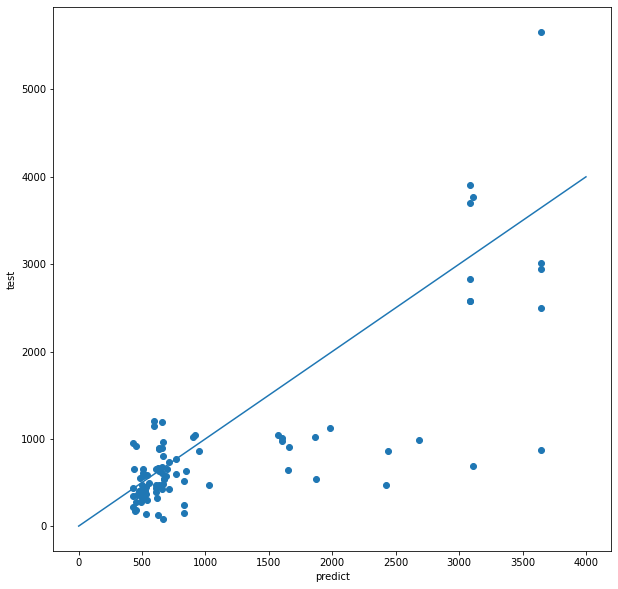

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(prediction_median_total['ensemble'], prediction_median_total['real'])
plt.plot([1,100,1000,4000],[1,100,1000,4000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()



> 2. gas_leak 데이터



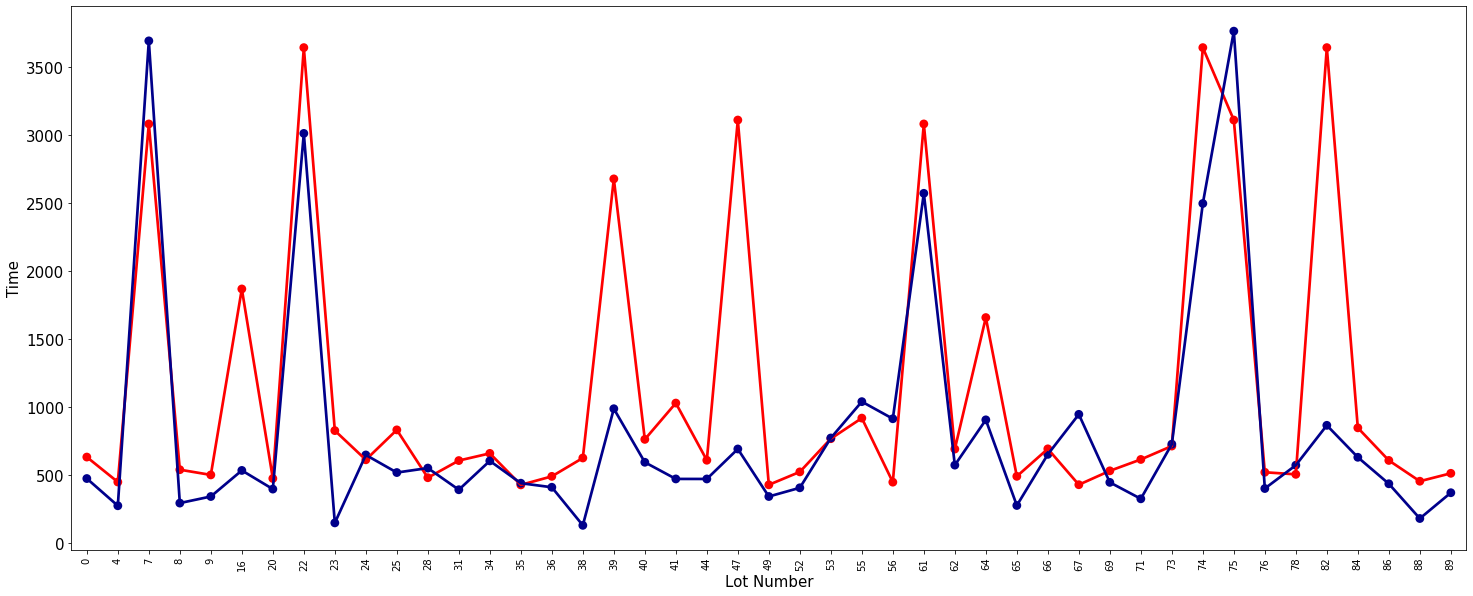

In [ ]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='ensemble', data=prediction_median_total[prediction_median_total['gas_leak']==1].reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction_median_total[prediction_median_total['gas_leak']==1].reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

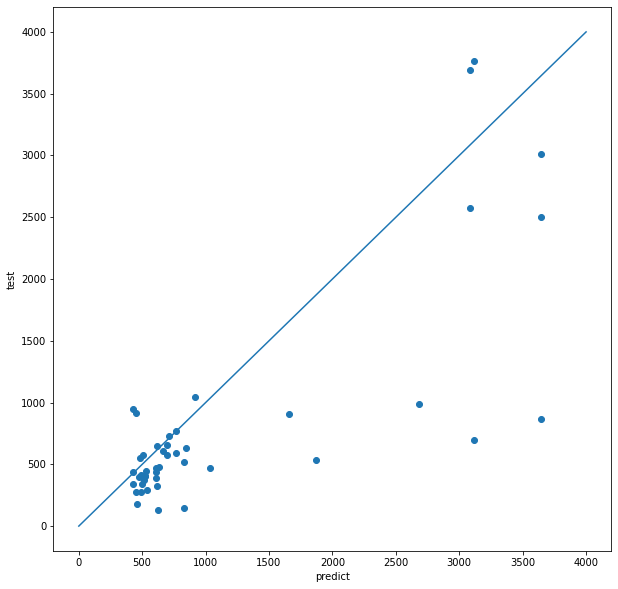

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(prediction_median_total[prediction_median_total['gas_leak']==1]['ensemble'], prediction_median_total[prediction_median_total['gas_leak']==1]['real'])
plt.plot([1,100,1000,4000],[1,100,1000,4000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()



> 3. alive data



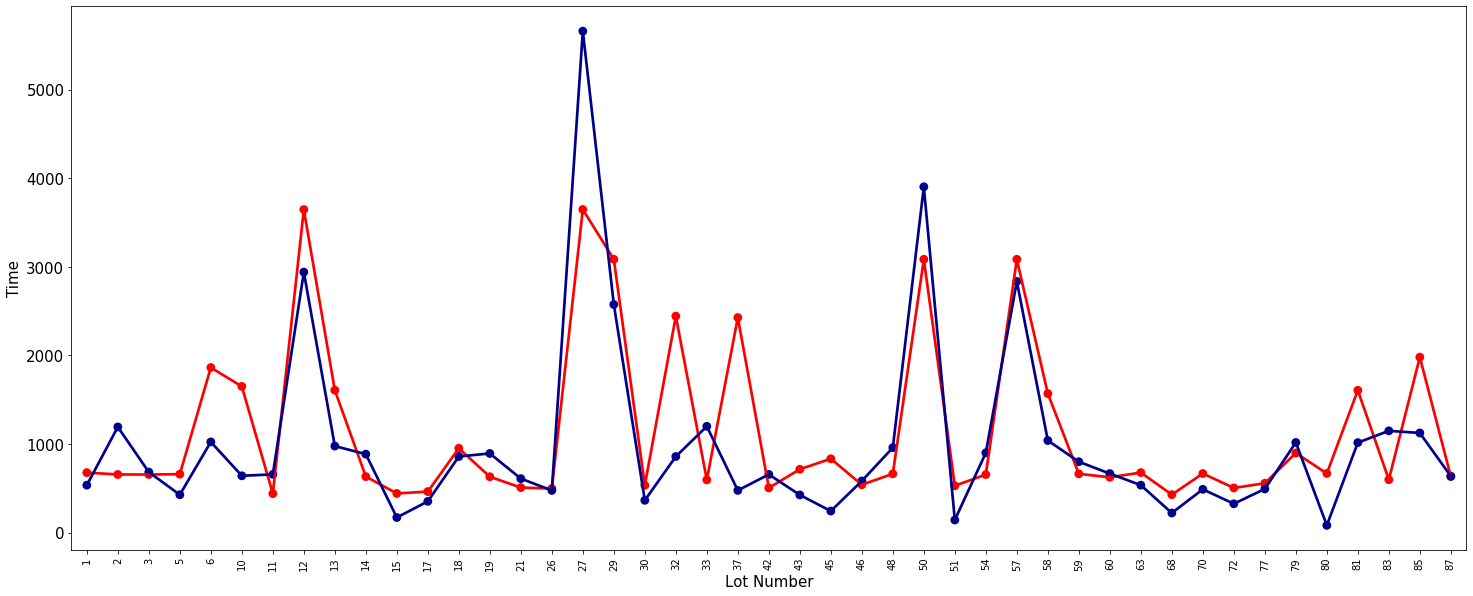

In [ ]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='ensemble', data=prediction_median_total[prediction_median_total['gas_leak']!=1].reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction_median_total[prediction_median_total['gas_leak']!=1].reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

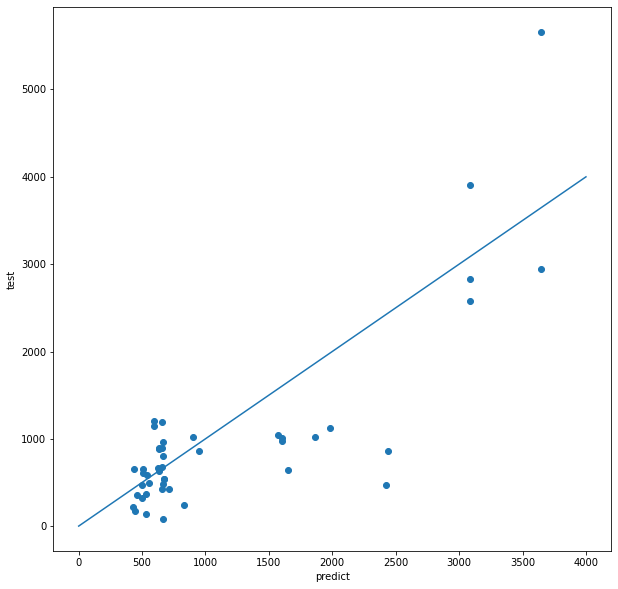

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(prediction_median_total[prediction_median_total['gas_leak']!=1]['ensemble'], prediction_median_total[prediction_median_total['gas_leak']!=1]['real'])
plt.plot([1,100,1000,4000],[1,100,1000,4000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()

- 개별 모델 그래프

Xgbse

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


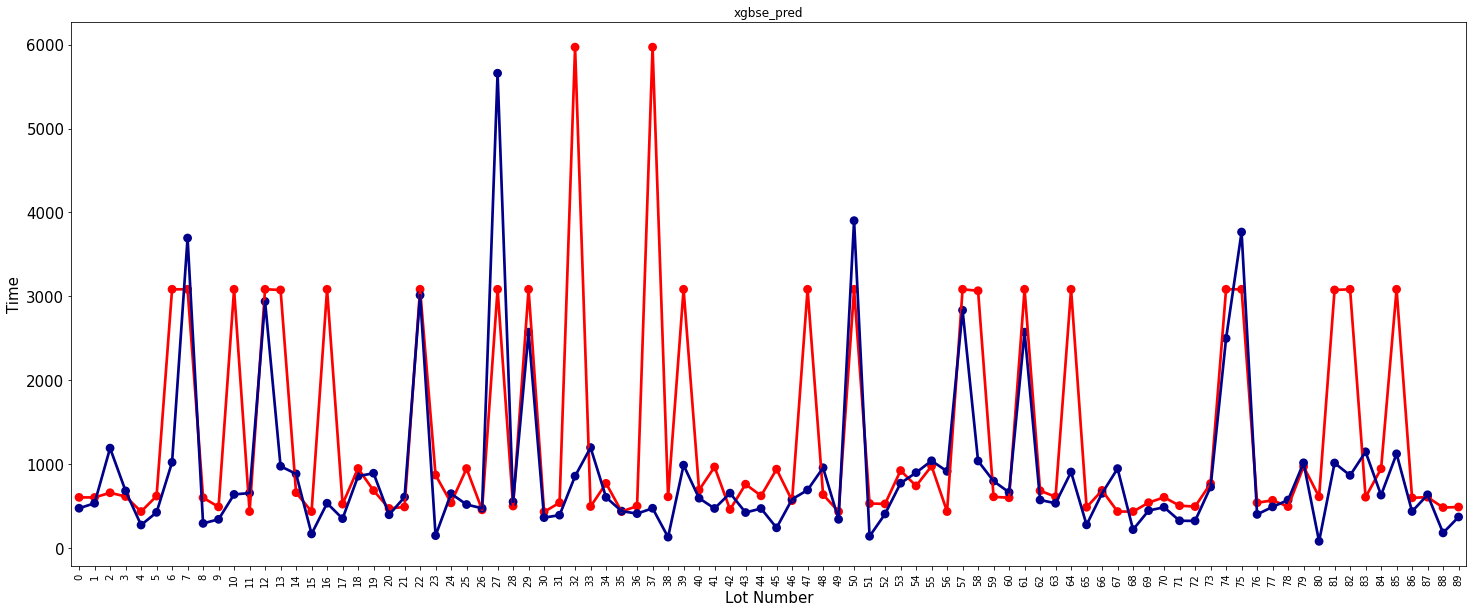

In [54]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='xgbse_pred', data=prediction_median_total.reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction_median_total.reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.title("xgbse_pred")
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

rsf

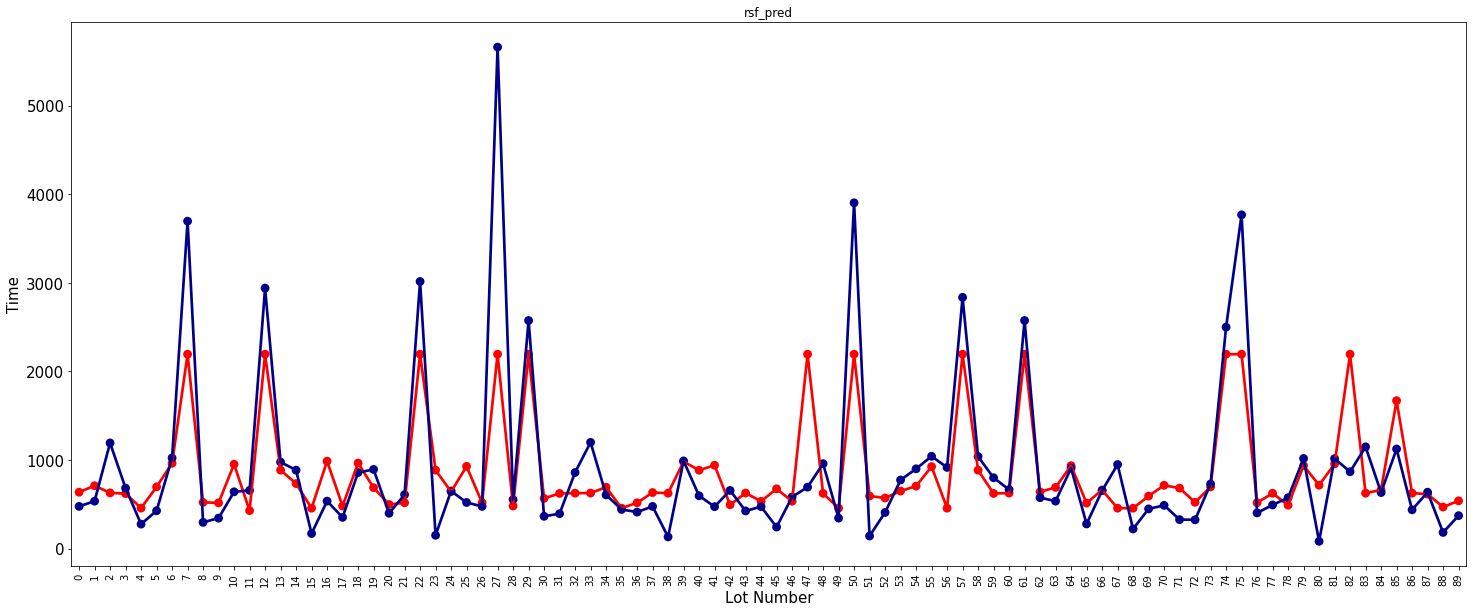

In [55]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='rsf_pred', data=prediction_median_total.reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction_median_total.reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.title("rsf_pred")
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

deepsurv

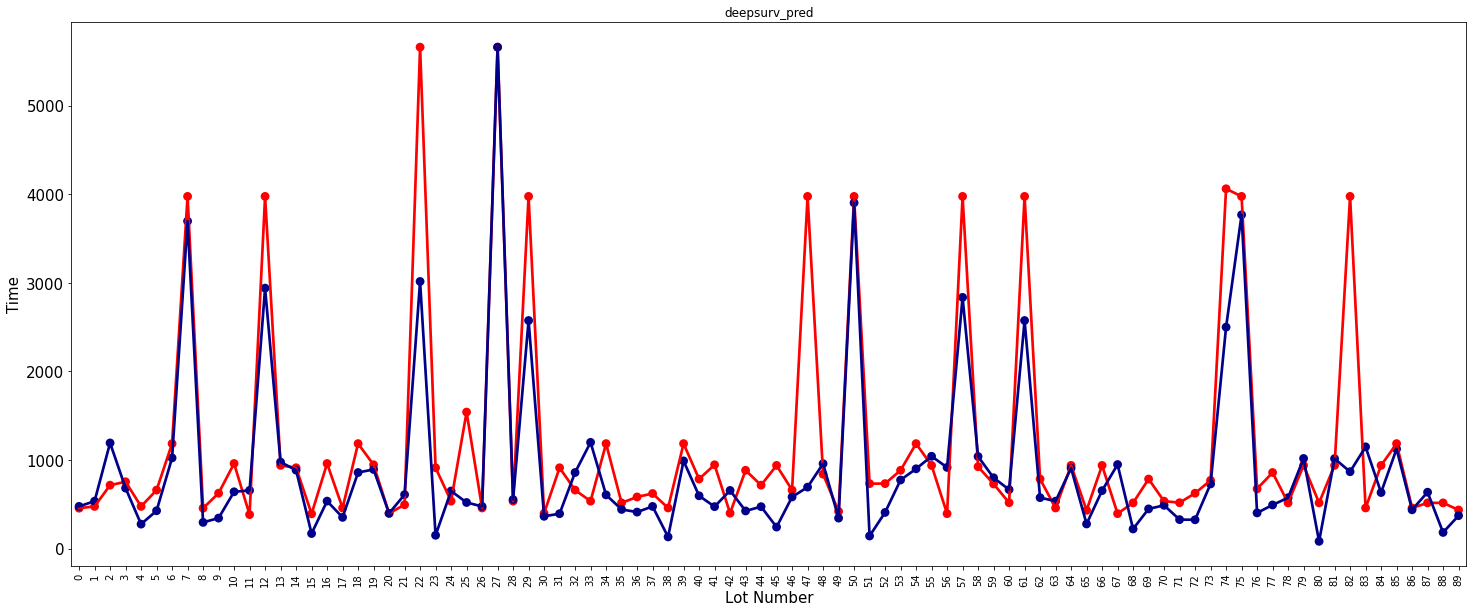

In [56]:
plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='deepsurv_pred', data=prediction_median_total.reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction_median_total.reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.title("deepsurv_pred")
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()